In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from metrics import custom_score, ultimate_score
from sklearn.inspection import permutation_importance
from boruta import BorutaPy
from collections import Counter
from itertools import product, chain, combinations
import warnings
from pandasql import sqldf
import seaborn as sns
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings('ignore')

random_seed = 42
np.random.seed(random_seed)

TEST_SETS_NUMBER = 5

### LOADING DATA

In [2]:
X = pd.read_csv("data/x_train.txt", sep=" ", header=None)
y = pd.read_csv("data/y_train.txt", sep=" ", header=None)

def create_test_sets(X, y, random_seed, test_sets_number):

    skf = StratifiedKFold(n_splits=test_sets_number, shuffle=True, random_state=random_seed)

    datasets = {}

    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        datasets[f"fold_{fold_idx+1}"] = {
            "X_train": X_train_scaled,
            "X_test": X_test_scaled,
            "y_train": y_train.reset_index(drop=True),
            "y_test": y_test.reset_index(drop=True)
        }
    return datasets

datasets = create_test_sets(X, y, random_seed, TEST_SETS_NUMBER)

In [3]:
print('no of ones in y:', sum(y.values.ravel() == 1))
print('no of zeros in y:', sum(y.values.ravel() == 0))

no of ones in y: 2443
no of zeros in y: 2557


### FUNCTIONS

In [4]:
def get_sorted_features(init_model, X_train, y_train, feature_selection='mdi', **kwargs):
    model = init_model(**kwargs)
    model.fit(X_train, y_train)
    if feature_selection == 'mdi':
        try:
            importances = model.feature_importances_
        except AttributeError:
            importances = np.abs(model.coef_).reshape(-1,)
    elif feature_selection == 'permutation_importance':
        importances = permutation_importance(model, X_train, y_train).importances_mean
    
    feature_names = np.arange(X_train.shape[1])
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    features = np.array(feature_importance_df.feature)
    
    return features

def calculate_model(init_model, X_train, y_train, X_test, y_test, selected_features, **kwargs):

    X_train_filtered = X_train[:, selected_features]
    X_test_filtered = X_test[:, selected_features]
    
    model = init_model(**kwargs)
    model.fit(X_train_filtered, y_train)
    prob = model.predict_proba(X_test_filtered)
    
    k_test = int(len(y_test) * 0.2) # 20% of data should be ones
    score = custom_score(y_test, prob, k_test)
    ult_score = ultimate_score(y_test, prob, k_test, len(selected_features))
    return score, ult_score

### GETTING MOST IMPORTANT FEATURES

In [ ]:
# general parameters
repeats = 5
selectors = ['mdi', 'permutation_importance']
model = LogisticRegression

# model's grid search parameters
penalty_list = ['l1', 'l2', None]
C_list = [0.01, 0.1, 1, 10]
solver_list = ['liblinear', 'lbfgs']
# max_iter = 200

param_grid = [
    {'penalty': penalty,
     'C': C,
     'solver': solver
     }
    for penalty, 
        C,
        solver
        in product(penalty_list,
                   C_list,
                   solver_list
                   )
        if not (penalty == 'l1' and solver == 'lbfgs')
        and not (penalty is None and solver == 'liblinear')        
]

# grid search
def do_grid_search_features(model, datasets, test_sets_number, selectors, param_grid, repeats):
    considered_best_features_no = 50
    features_counter = []
    for test_idx in range(1, test_sets_number+1):
        for selector in selectors:
            for params in param_grid:
                print(test_idx, selector, params)
                for i in range(repeats):
                    features = get_sorted_features(
                        model,
                        datasets[f'fold_{test_idx}']['X_train'],
                        datasets[f'fold_{test_idx}']['y_train'],
                        feature_selection=selector,
                        **params,
                        max_iter=200,
                        n_jobs=-1,
                        random_state=i
                    )
                    
                    features_counter.extend(features[:considered_best_features_no])

    return Counter(features_counter)

# features counter
feature_counts = do_grid_search_features(model, datasets, TEST_SETS_NUMBER, selectors, param_grid, repeats)

# 26 min

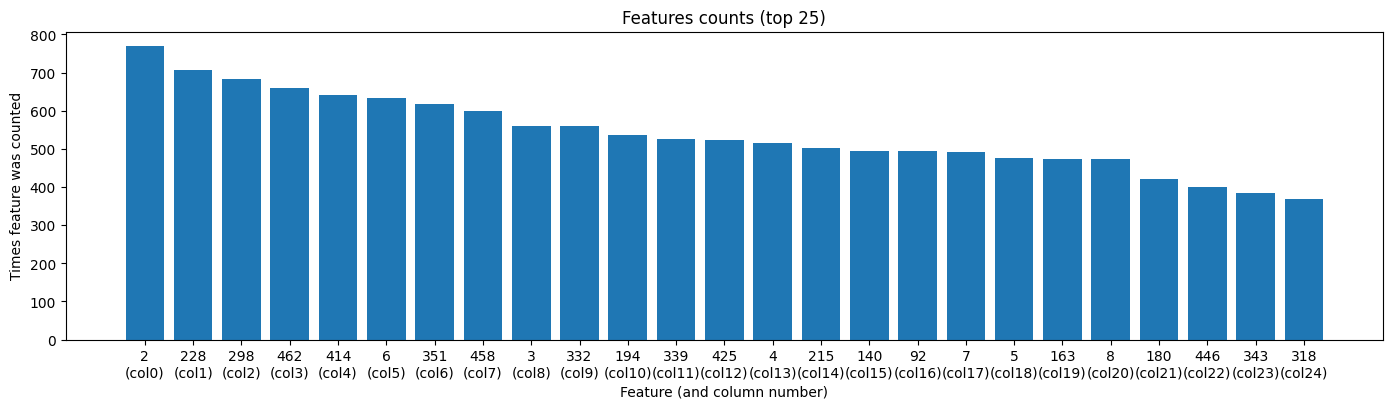

In [10]:
# presenting features ranking

features_to_present = 25
def plot_feature_ranking(feature_counts, features_to_present, save=False):
    plt.figure(figsize=(17, 4))

    x_sorted = [str(feature) for feature, count in feature_counts.most_common()[:features_to_present]]
    y_sorted = [count for feature, count in feature_counts.most_common()[:features_to_present]]

    plt.bar(x_sorted, y_sorted)
    plt.ylabel('Times feature was counted')
    plt.xlabel(f'Feature {"(and column number)" if not save else ""}')
    if not save: plt.title(f'Features counts (top {features_to_present})')
    if not save: xtick_labels = [f'{feature}\n(col{i})' for i, feature in zip(range(features_to_present), x_sorted)]
    if not save:plt.xticks(ticks=range(len(x_sorted)), labels=xtick_labels)

    if not save:
        plt.show()
        return x_sorted
    else:
        plt.savefig('results_to_report/feature_ranking_logistic_regression.png')
        plt.close()

plot_feature_ranking(feature_counts, features_to_present, save=True)
features_sorted = plot_feature_ranking(feature_counts, features_to_present, save=False)

In [11]:
# arbitrary choosing considered top features based on chart above
top_features_threshold = 7 # up to 'col<top_features_threshold>' including that column

top_features = [int(feature_name) for feature_name in features_sorted[:top_features_threshold+1]]
print('Top features selected for further tests:', top_features)

Top features selected for further tests: [2, 228, 298, 462, 414, 6, 351, 458]


### TESTING MODEL ON BEST FEATURES

In [ ]:
def subsets(lst, max_subset_len):
    """Return 1-max_subset_len len subsets of the input list """
    return [list(subset) for r in range(1, max_subset_len + 1) for subset in combinations(lst, r)]

# general parameters
repeats = 5
max_subset_len = 3
model = LogisticRegression

# model's grid search parameters
penalty_list = ['l1', 'l2', None]
C_list = [0.01, 0.1, 1, 10]
solver_list = ['liblinear', 'lbfgs']
# max_iter = 200

param_grid = [
    {'penalty': penalty,
     'C': C,
     'solver': solver
     }
    for penalty, 
        C,
        solver
        in product(penalty_list,
                   C_list,
                   solver_list
                   )
        if not (penalty == 'l1' and solver == 'lbfgs')
        and not (penalty is None and solver == 'liblinear')        
]

# grid search
def do_grid_search_model(model, datasets, test_sets_number, param_grid, repeats, top_features, max_subset_len):
    subsets_top_features = subsets(top_features, max_subset_len)
    result_rows = []
    param_keys = list(param_grid[0].keys())

    for test_idx in range(1, test_sets_number+1):
        for params in param_grid:
            print(test_idx, params)
            for selected_features in subsets_top_features:

                scores = []
                ult_scores = []
                for i in range(repeats):
                    score, ult_score = calculate_model(model, 
                                                    datasets[f'fold_{test_idx}']['X_train'], 
                                                    datasets[f'fold_{test_idx}']['y_train'], 
                                                    datasets[f'fold_{test_idx}']['X_test'], 
                                                    datasets[f'fold_{test_idx}']['y_test'], 
                                                    selected_features, 
                                                    **params, 
                                                    max_iter = 200,
                                                    n_jobs=-1, 
                                                    random_state=i)
                
                    scores.append(score)
                    ult_scores.append(ult_score)


                result_row = [
                        test_idx,
                        len(selected_features),
                        ', '.join([str(x) for x in selected_features]),
                        round(np.mean(scores), 4),
                        round(np.mean(ult_scores)),
                        ', '.join([f'{key}={value}' for key, value in params.items()])
                    ]
                result_row.extend([str(params.get(k)) for k in param_keys])

                result_rows.append(result_row)

    results_df = pd.DataFrame(result_rows, columns = ["test_set_id", "no_of_features", "features", "precision", "ultimate_score", "params_merged"] + param_keys)
    
    return results_df

results_df = do_grid_search_model(model, datasets, TEST_SETS_NUMBER, param_grid, repeats, top_features, max_subset_len)
results_df.to_csv('results_to_report/acc_test_grid_search_logistic_regression.csv', index=False)

# 6 min

### ANALYSIS

In [14]:
results_df.sample(2)

,test_set_id,no_of_features,features,precision,ultimate_score,params_merged,penalty,C,solver
5276,4,2,"414, 458",0.64,6000,"penalty=l2, C=1, solver=lbfgs",l2,1,lbfgs
748,1,2,"2, 6",0.69,6500,"penalty=l2, C=1, solver=liblinear",l2,1,liblinear


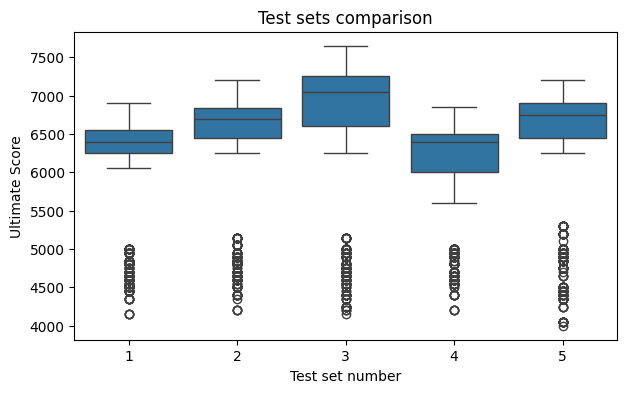

In [15]:
# TEST SETS COMPARISON
plt.figure(figsize=(7, 4))
sns.boxplot(x='test_set_id', y='ultimate_score', data=results_df)
plt.title('Test sets comparison')
plt.ylabel('Ultimate Score')
plt.xlabel('Test set number')
plt.show()

In [21]:
sqldf('''
select features, params_merged,
      avg(precision) as precision_avg, 
      avg(ultimate_score) as ultimate_score_avg
  from results_df
 --where no_of_features = 2
 group by features, params_merged
 order by ultimate_score_avg desc
''').head(15)

,features,params_merged,precision_avg,ultimate_score_avg
0,2,"penalty=None, C=0.01, solver=lbfgs",0.725,7050.0
1,2,"penalty=None, C=0.1, solver=lbfgs",0.725,7050.0
2,2,"penalty=None, C=1, solver=lbfgs",0.725,7050.0
3,2,"penalty=None, C=10, solver=lbfgs",0.725,7050.0
4,2,"penalty=l1, C=0.01, solver=liblinear",0.725,7050.0
5,2,"penalty=l1, C=0.1, solver=liblinear",0.725,7050.0
6,2,"penalty=l1, C=1, solver=liblinear",0.725,7050.0
7,2,"penalty=l1, C=10, solver=liblinear",0.725,7050.0
8,2,"penalty=l2, C=0.01, solver=lbfgs",0.725,7050.0
9,2,"penalty=l2, C=0.01, solver=liblinear",0.725,7050.0


In [24]:
sqldf('''
select features, params_merged,
      avg(precision) as precision_avg, 
      avg(ultimate_score) as ultimate_score_avg
  from results_df
 where no_of_features = 2
 group by features, params_merged
 order by precision_avg desc
''').head(15)

,features,params_merged,precision_avg,ultimate_score_avg
0,"2, 458","penalty=l2, C=0.01, solver=lbfgs",0.737,6970.0
1,"2, 458","penalty=l2, C=0.01, solver=liblinear",0.737,6970.0
2,"2, 458","penalty=None, C=0.01, solver=lbfgs",0.736,6960.0
3,"2, 458","penalty=None, C=0.1, solver=lbfgs",0.736,6960.0
4,"2, 458","penalty=None, C=1, solver=lbfgs",0.736,6960.0
5,"2, 458","penalty=None, C=10, solver=lbfgs",0.736,6960.0
6,"2, 458","penalty=l1, C=1, solver=liblinear",0.736,6960.0
7,"2, 458","penalty=l1, C=10, solver=liblinear",0.736,6960.0
8,"2, 458","penalty=l2, C=0.1, solver=lbfgs",0.736,6960.0
9,"2, 458","penalty=l2, C=0.1, solver=liblinear",0.736,6960.0


### BEST CONFIGURATION Y SAVE

In [28]:
# params
model = LogisticRegression
repeats = 10

params = {'penalty': 'l2',
          'C': 0.01, 
          'solver': 'lbfgs'
        }

selected_features = [2, 458]

def save_y(model, datasets, test_set_number, repeats, params, selected_features):
    for test_idx in range(1, test_set_number+1):
        scores = []
        ult_scores = []
        for i in range(repeats):
            score, ult_score = calculate_model(model, 
                                            datasets[f'fold_{test_idx}']['X_train'], 
                                            datasets[f'fold_{test_idx}']['y_train'], 
                                            datasets[f'fold_{test_idx}']['X_test'], 
                                            datasets[f'fold_{test_idx}']['y_test'], 
                                            selected_features, 
                                            **params, 
                                            max_iter = 200,
                                            n_jobs=-1, 
                                            random_state=i)

            scores.append(score)
            ult_scores.append(ult_score)
    
    print('Precision on test: {:.4f}'.format(np.mean(scores)))
    print('Ultimate score on test: {:2f}'.format(np.mean(ult_scores)))

    X_train_full = pd.read_csv("data/x_train.txt", sep=" ", header=None).values
    Y_train_full = pd.read_csv("data/y_train.txt", sep=" ", header=None).values.ravel()
    X_final = pd.read_csv("data/x_test.txt", sep=" ", header=None)
    
    scaler = StandardScaler()
    X_train_full = scaler.fit_transform(X_train_full)
    X_final = scaler.transform(X_final)

    X_train_filtered = X_train_full[:, selected_features]
    X_final_filtered = X_final[:, selected_features]
    
    ones_to_predict = 1000

    model = model(**params)
    model.fit(X_train_filtered, Y_train_full)
    y_pred_probs = model.predict_proba(X_final_filtered)

    top_k_indices = np.argsort(y_pred_probs[:, 1])[::-1][:ones_to_predict]
    y_pred_k = np.zeros(len(X_final), dtype=int)
    y_pred_k[top_k_indices] = 1

    pd.DataFrame([[value] for value in y_pred_k], columns=['y']).to_csv('results_to_report/y_solution_logistic_regression.csv', index=False)

    
    print('\ny saved')
    print('\nfeatures used: ', ', '.join([f'{key}={value}' for key, value in params.items()]))
    print('columns used: ', selected_features)

save_y(model, datasets, TEST_SETS_NUMBER, repeats, params, selected_features)

Precision on test: 0.7400
Ultimate score on test: 7000.000000

y saved

features used:  penalty=l2, C=0.01, solver=lbfgs
columns used:  [2, 458]
